# Investment Ranking

In [1]:
#The following code computes and summarizes the investment ranking by Neighborhoods in selected ZIP codes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import gmaps
import numpy as np
import seaborn as sns

from config import gkey
gmaps.configure(api_key=gkey)

### Import Data File

In [3]:
# read file with all needed data
file = "Resources/all_data_merged.csv"
all_data = pd.read_csv(file)
del all_data['Unnamed: 0']
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26253 entries, 0 to 26252
Data columns (total 39 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Address                                     26253 non-null  object 
 1   Latitude                                    26253 non-null  float64
 2   Longitude                                   26253 non-null  float64
 3   Flood Description                           20837 non-null  object 
 4   Flood Zone                                  26253 non-null  object 
 5   Flood Risk                                  26253 non-null  int64  
 6   SITE_ADDR_1                                 26253 non-null  object 
 7   ACCOUNT                                     26253 non-null  float64
 8   Zip Code                                    26253 non-null  int64  
 9   NEIGHBORHOOD_CODE                           26253 non-null  float64
 10  NEIGHBORHO

## Build Lower Triangle Correlation Matrix

In [4]:
# set up data for correlation matrix
correlation_data = all_data[['Flood Risk','SQ_FT','ACREAGE','TOTAL_APPRAISED_VALUE_2019',
                                        'crime_rank','Average School Rating','pct_change']]
correlation_data.head()

,Flood Risk,SQ_FT,ACREAGE,TOTAL_APPRAISED_VALUE_2019,crime_rank,Average School Rating,pct_change
0,1,1944,1765,299000,0.0,80.0,0.000000
1,1,1944,1515,296400,0.0,80.0,0.000000
2,1,1944,1720,299803,0.0,80.0,0.000000
3,1,1924,1797,331080,0.0,80.0,0.000000
4,1,1965,1533,287800,0.0,80.0,-14.717082


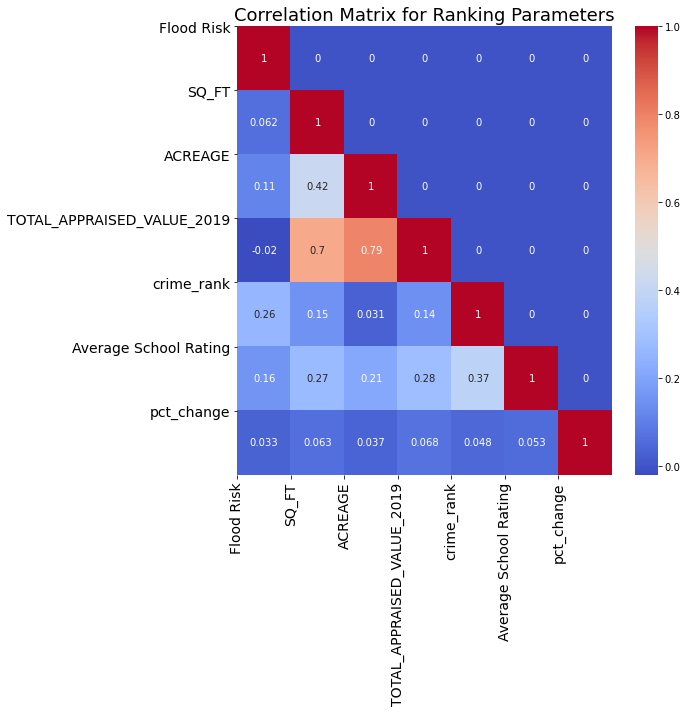

In [5]:
# create a correlation matrix
corr = correlation_data.corr()
corr = corr.unstack().sort_values()
corr = corr.unstack()
corr2=np.tril(corr, k=0)
f, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr2,cmap="coolwarm",annot=True)
mask = np.triu(np.ones_like(corr2, dtype=np.bool))
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
plt.title("Correlation Matrix for Ranking Parameters",fontsize=18)
plt.tight_layout()
plt.savefig("Output/correlation_matrix.png")

## Ranking Parameters Normalization

In [6]:
# DataFrame for homes below $1M
homes_less_than_1M = all_data.loc[all_data['TOTAL_APPRAISED_VALUE_2019']<=1000000,:]
homes_less_than_1M.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17632 entries, 0 to 26250
Data columns (total 39 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Address                                     17632 non-null  object 
 1   Latitude                                    17632 non-null  float64
 2   Longitude                                   17632 non-null  float64
 3   Flood Description                           14018 non-null  object 
 4   Flood Zone                                  17632 non-null  object 
 5   Flood Risk                                  17632 non-null  int64  
 6   SITE_ADDR_1                                 17632 non-null  object 
 7   ACCOUNT                                     17632 non-null  float64
 8   Zip Code                                    17632 non-null  int64  
 9   NEIGHBORHOOD_CODE                           17632 non-null  float64
 10  NEIGHBORHO

In [7]:
# Calculate sales per neighborhood
sales=homes_less_than_1M.groupby('NEIGHBORHOOD')['2019 Sales'].sum()
sales=pd.DataFrame(sales)
sales=sales.reset_index()
min=sales['2019 Sales'].min()
max=sales['2019 Sales'].max()
sales['Sales Index']=(sales['2019 Sales']-min)/(max-min)*100

In [8]:
# Merge sales count and index with maindataframe
homes_less_than_1M=pd.merge(homes_less_than_1M,sales,on="NEIGHBORHOOD")
homes_less_than_1M.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17632 entries, 0 to 17631
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Address                                     17632 non-null  object 
 1   Latitude                                    17632 non-null  float64
 2   Longitude                                   17632 non-null  float64
 3   Flood Description                           14018 non-null  object 
 4   Flood Zone                                  17632 non-null  object 
 5   Flood Risk                                  17632 non-null  int64  
 6   SITE_ADDR_1                                 17632 non-null  object 
 7   ACCOUNT                                     17632 non-null  float64
 8   Zip Code                                    17632 non-null  int64  
 9   NEIGHBORHOOD_CODE                           17632 non-null  float64
 10  NEIGHBORHO

In [9]:
# Normalize data for each parameter
max=homes_less_than_1M['Offense Count'].max()
min=homes_less_than_1M['Offense Count'].min()
homes_less_than_1M["Crime Index"]=(homes_less_than_1M['Offense Count']-min)/(max-min)*100

max=homes_less_than_1M['Average School Rating'].max()
min=homes_less_than_1M['Average School Rating'].min()
homes_less_than_1M["School Rating Index"]=(homes_less_than_1M['Average School Rating']-min)/(max-min)*100

max=homes_less_than_1M['ACREAGE'].max()
min=homes_less_than_1M['ACREAGE'].min()
homes_less_than_1M["Acreage Index"]=(homes_less_than_1M['ACREAGE']-min)/(max-min)*100

max=homes_less_than_1M['SQ_FT'].max()
min=homes_less_than_1M['SQ_FT'].min()
homes_less_than_1M["SQ_FT Index"]=(homes_less_than_1M['SQ_FT']-min)/(max-min)*100

max=homes_less_than_1M['Flood Risk'].max()
min=homes_less_than_1M['Flood Risk'].min()
homes_less_than_1M["Flood Risk Index"]=(homes_less_than_1M['Flood Risk']-min)/(max-min)*100


max=homes_less_than_1M['pct_change'].max()
homes_less_than_1M['Valuation Index']=homes_less_than_1M['pct_change']/max*100

homes_less_than_1M.sample(5)

,Address,Latitude,Longitude,Flood Description,Flood Zone,Flood Risk,SITE_ADDR_1,ACCOUNT,Zip Code,NEIGHBORHOOD_CODE,...,pct_change,2019 Sales_x,2019 Sales_y,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index
134,"1517 ONEIL ST HOUSTON, Texas 77019",29.75249,-95.38287,AREA OF MINIMAL FLOOD HAZARD,X,1,1517 ONEIL ST,1.206200e+12,77019,8316.08,...,-2.287498,1,279,26.029963,33.922997,0.000000,6.090912,18.385982,0.0,-1.056223
11720,"3531 DURHILL ST HOUSTON, Texas 77025",29.68458,-95.43336,NaN,AE,3,3531 DURHILL ST,8.059300e+11,77025,7452.00,...,2.087530,1,475,44.382022,32.362123,63.636364,27.086155,30.750247,100.0,0.963890
16503,"9910 ADELINE LN HOUSTON, Texas 77054",29.67508,-95.42578,AREA OF MINIMAL FLOOD HAZARD,X,1,9910 ADELINE LN,1.231830e+12,77054,7454.04,...,0.000000,1,23,2.059925,52.731530,54.545455,10.355245,34.168312,0.0,0.000000
2538,"4211 DRAKE ST B HOUSTON, Texas 77005",29.72514,-95.44514,AREA OF MINIMAL FLOOD HAZARD,X,1,4211 DRAKE ST B,1.264680e+12,77005,7444.02,...,8.010932,1,265,24.719101,0.000000,100.000000,5.208876,27.813425,0.0,3.698945
14525,"3110 SUFFOLK DR HOUSTON, Texas 77027",29.73685,-95.44772,AREA OF MINIMAL FLOOD HAZARD,X,1,3110 SUFFOLK DR,7.510700e+11,77027,8313.00,...,9.756098,1,160,14.887640,25.702393,100.000000,30.385110,20.582428,0.0,4.504753


In [10]:
# Calculate scores for each address.
# Weights to be entered in a scale from 0 to 10, with 0 not important and 10 highly important
w_sales=8
w_crime=5
w_schools=7
w_acreage=6
w_SQ_FT=6
w_flood=8
w_change=10
total_weights=w_sales+w_crime+w_schools+w_acreage+w_SQ_FT+w_flood+w_change

homes_less_than_1M["Sales Index_W"]=w_sales*homes_less_than_1M['Sales Index']
homes_less_than_1M['Crime Index_W']= w_crime*homes_less_than_1M['Crime Index']
homes_less_than_1M["School Rating Index_W"]=w_schools*homes_less_than_1M['School Rating Index']
homes_less_than_1M["Acreage Index_W"]= w_acreage*homes_less_than_1M['Acreage Index']
homes_less_than_1M["SQ_FT_Index_W"]= w_SQ_FT*homes_less_than_1M['SQ_FT Index']
homes_less_than_1M["Flood Risk Index_W"]=w_flood*homes_less_than_1M['Flood Risk Index']
homes_less_than_1M['Valuation Index_W']= w_change*homes_less_than_1M['Valuation Index']

homes_less_than_1M["Score"]=round((w_sales*homes_less_than_1M['Sales Index']-
                                   w_crime*homes_less_than_1M['Crime Index']+
                                   w_schools*homes_less_than_1M['School Rating Index']+
                                   w_acreage*homes_less_than_1M['Acreage Index']+
                                   w_SQ_FT*homes_less_than_1M['SQ_FT Index']-
                                   w_flood*homes_less_than_1M['Flood Risk Index']+
                                   w_change*homes_less_than_1M['Valuation Index'])/total_weights,2)
max=homes_less_than_1M["Score"].max()
min=homes_less_than_1M["Score"].min()
max=homes_less_than_1M["Score"]=(homes_less_than_1M["Score"]-min)/(max-min)*100
homes_less_than_1M.columns

Index(['Address', 'Latitude', 'Longitude', 'Flood Description', 'Flood Zone',
       'Flood Risk', 'SITE_ADDR_1', 'ACCOUNT', 'Zip Code', 'NEIGHBORHOOD_CODE',
       'NEIGHBORHOOD_GROUP', 'TOTAL_BUILDING_AREA', 'TOTAL_LAND_AREA',
       'ACREAGE', 'LAND_VALUE_2019', 'TOTAL_APPRAISED_VALUE_2019',
       'TOTAL_MARKET_VALUE_2019', 'LAND_VALUE_2018',
       'TOTAL_APPRAISED_VALUE_2018', 'TOTAL_MARKET_VALUE_2018',
       'pct_change_land_value_2018_2019',
       'pct_change_total_appraised_value_2018_2019',
       'pct_change_total_market_value_2018_2019', 'SQ_FT', 'NEIGHBORHOOD',
       'Offense Count', 'crime_rank', 'Elementary Public School ID',
       'Elementary Public School Name', 'Elementary Public School Rating',
       'Public Middle School ID', 'Public Middle School Name',
       'Public Middle School Rating', 'Public High School ID',
       'Public High School Name', 'Public High School Rating',
       'Average School Rating', 'pct_change', '2019 Sales_x', '2019 Sales_y',
      

In [11]:
homes_less_than_1M.to_csv('Output/homes_less_than_1M.csv')

## Plot Ranking Results per Investor's Budget

In [12]:
# look at only the parameters of interest
parameter_and_score = homes_less_than_1M[["Sales Index",'Crime Index', 'School Rating Index', 'Acreage Index',
       'SQ_FT Index', 'Flood Risk Index', 'Valuation Index','Score','TOTAL_APPRAISED_VALUE_2019','NEIGHBORHOOD']]
#parameter_and_score.rename(columns={'TOTAL_APPRAISED_VALUE_2019':'Total Appraised Value'},inplace=True)
parameter_and_score.head()

,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index,Score,TOTAL_APPRAISED_VALUE_2019,NEIGHBORHOOD
0,1.779026,100.0,27.272727,6.129111,22.013820,0.0,0.000000,13.722094,299000,BALDWIN SQ/TUAM SQ/MCGREGOR
1,1.779026,100.0,27.272727,5.260965,22.013820,0.0,0.000000,13.529638,296400,BALDWIN SQ/TUAM SQ/MCGREGOR
2,1.779026,100.0,27.272727,5.972844,22.013820,0.0,0.000000,13.683603,299803,BALDWIN SQ/TUAM SQ/MCGREGOR
3,1.779026,100.0,27.272727,6.240233,21.767029,0.0,0.000000,13.683603,331080,BALDWIN SQ/TUAM SQ/MCGREGOR
4,1.779026,100.0,27.272727,5.323471,22.272952,0.0,-6.795424,10.989222,287800,BALDWIN SQ/TUAM SQ/MCGREGOR


In [13]:
# group parameters by neighborhood name
neighborhood_group = parameter_and_score.groupby(["NEIGHBORHOOD"]).mean()
neighborhood_group.head()

,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index,Score,TOTAL_APPRAISED_VALUE_2019
NEIGHBORHOOD,,,,,,,,,
1841 MARSHALL STREET TH,0.749064,26.664932,36.363636,2.577429,13.430953,0.0,-0.410090,27.005816,165052.000000
2300 STEEL STREET,0.468165,26.664932,54.545455,16.907432,26.055035,0.0,0.000000,38.202463,526974.666667
AFTON OAKS,19.943820,25.702393,88.275276,34.497428,28.383238,0.0,1.493337,58.647918,799890.046729
AFTON OAKS (S. OF RICHMOND),9.737828,25.702393,92.207792,30.173381,24.797983,0.0,1.460694,54.724880,565010.142857
ALABAMA COURTS PLACE,3.370787,25.702393,100.000000,12.767565,34.633548,0.0,1.732836,53.222853,601092.243243


In [14]:
# To get to the top list, neighnorhoods need positive valuation index and non-zero sales index
neighborhood_group=neighborhood_group.loc[(neighborhood_group['Valuation Index']>0)&(neighborhood_group['Sales Index']>0),:]

min=neighborhood_group['Valuation Index'].min()
max=neighborhood_group['Valuation Index'].max()
min=neighborhood_group['Valuation Index']=(neighborhood_group['Valuation Index']-min)/(max-min)*100

# sort scores
rank_all = neighborhood_group.sort_values('Score',ascending=False)
rank_all

,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index,Score,TOTAL_APPRAISED_VALUE_2019
NEIGHBORHOOD,,,,,,,,,
HYDE PARK MAIN 6-ROW T/H,100.000000,32.524343,42.503614,7.815857,31.815757,0.000000,8.231140,63.994430,544158.155285
COLLEGE CT. PL. (ROW T/HS)(91),24.719101,0.000000,100.000000,8.226971,30.071383,0.000000,26.071519,62.863088,540422.822642
SUNSET TERR(N OF BISSONNET),12.546816,0.000000,98.855219,30.796058,25.893752,0.000000,19.651113,62.835942,726596.555556
WEST U - COLLEGE CT PL,19.850187,0.000000,91.250534,17.897518,27.592356,1.408451,0.000000,59.347205,718864.413146
AFTON OAKS,19.943820,25.702393,88.275276,34.497428,28.383238,0.000000,16.778371,58.647918,799890.046729
...,...,...,...,...,...,...,...,...,...
VANDERBILT PALACE T/H (>1981),1.029963,0.000000,54.545455,0.000000,27.225239,100.000000,45.672850,10.636387,481299.416667
"RUTGERS PLACE TH I,II",1.591760,0.000000,59.595960,0.000000,26.069431,100.000000,3.626377,10.476007,404153.222222
UNIVERSITY SQUARE T/H,5.617978,32.362123,56.780924,10.332759,30.721926,100.000000,15.515432,8.592675,586997.360656


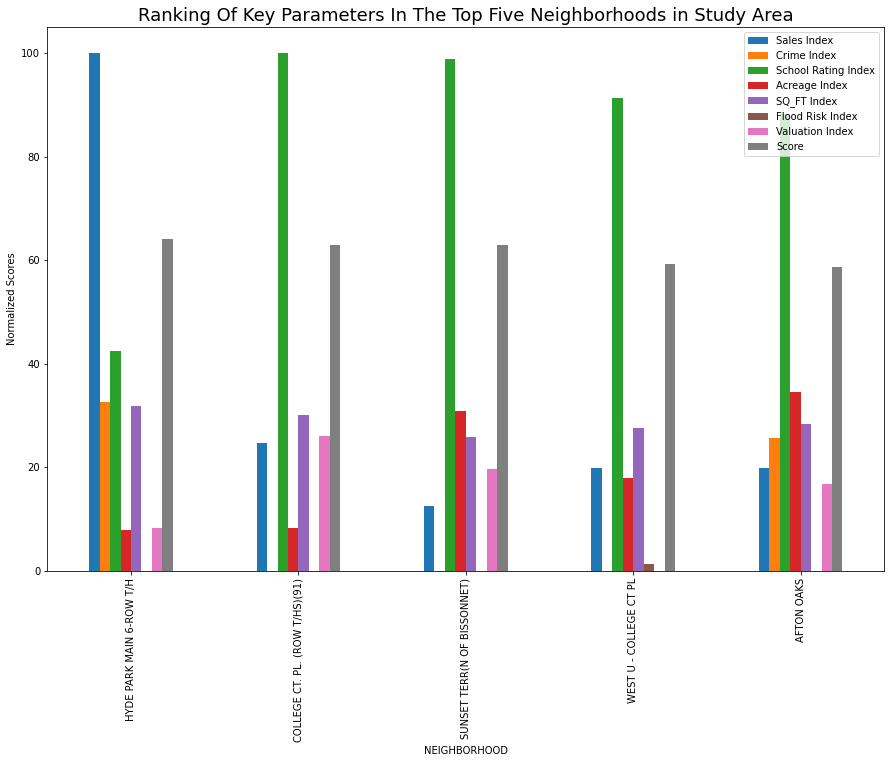

In [15]:
# Bar plot for all area of study
ranked = rank_all.iloc[:,:-1]
ranked=ranked.head()
ranked.plot(kind='bar',figsize=(15,10))
plt.ylabel("Normalized Scores")
plt.title("Ranking Of Key Parameters In The Top Five Neighborhoods in Study Area", fontsize=18)
plt.savefig('Output/Results_Bar_All.png')
plt.show()


In [16]:
#Build Data for Map of Selected Neighborhoods
lat_df=homes_less_than_1M.groupby('NEIGHBORHOOD')['Latitude'].mean()
lat_df=pd.DataFrame(lat_df)
lat_df=lat_df.reset_index()

lon_df=homes_less_than_1M.groupby('NEIGHBORHOOD')['Longitude'].mean()
lon_df=pd.DataFrame(lon_df)
lon_df=lon_df.reset_index()

zip_df=homes_less_than_1M.groupby('NEIGHBORHOOD')['Zip Code'].mean()
zip_df=pd.DataFrame(zip_df)
zip_df=zip_df.reset_index()

locations = pd.merge(lat_df,lon_df,on="NEIGHBORHOOD")
locations = pd.merge(locations,zip_df,on="NEIGHBORHOOD")
locations.head()


,NEIGHBORHOOD,Latitude,Longitude,Zip Code
0,1841 MARSHALL STREET TH,29.739330,-95.406290,77098.0
1,2300 STEEL STREET,29.739332,-95.415268,77098.0
2,AFTON OAKS,29.736569,-95.454162,77027.0
3,AFTON OAKS (S. OF RICHMOND),29.731555,-95.452912,77027.0
4,ALABAMA COURTS PLACE,29.736875,-95.435908,77027.0


In [17]:
#Build Map for selected Neighborhhods
locations_all=pd.merge(locations,ranked,on="NEIGHBORHOOD")
locations_all['Zip Code']=locations_all['Zip Code'].map("{:.0f}".format)
locations_all['Score']=locations_all['Score'].map("{:,.2f}".format)
locate=locations_all[['Latitude', 'Longitude']]

#Build Map
fig = gmaps.figure(map_type='TERRAIN', center=(29.7, -95.4), zoom_level=12,layout={
        'width': '1000px',
        'height': '700px',
        'padding': '3px',
        'border': '1px solid black'
})

info_box_template = """
<dl>
<dt>Neighborhood</dt><dd>{NEIGHBORHOOD}</dd>
<dt>Score</dt><dd>{Score}</dd>
<dt>ZIP_Code</dt><dd>{Zip Code}</dd>
</dl>
"""

info = [info_box_template.format(**row) for index, row in locations_all.iterrows()]

markers = gmaps.marker_layer(locate, info_box_content= info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='1000px'))

In [18]:
# extract the top five neighborhoods for home values 0-250k
top_neighborhoods_250 = rank_all.loc[rank_all['TOTAL_APPRAISED_VALUE_2019']<=250000,:]
top_250k_group = top_neighborhoods_250.groupby(['NEIGHBORHOOD']).mean()
ranked_250k = top_250k_group.sort_values('Score',ascending=False)
ranked_250k = ranked_250k.head()
ranked_250k.head(10)

,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index,Score,TOTAL_APPRAISED_VALUE_2019
NEIGHBORHOOD,,,,,,,,,
"WESTWOOD #2, PT 1",46.910112,32.362123,54.563564,27.107959,17.423568,0.000000,2.062251,51.849454,227923.611554
BRAYS BAYOU/GASMER/HWY 90 M/R,1.966292,32.362123,54.545455,46.474854,14.285875,0.000000,10.843431,42.050703,110968.681818
WESTWOOD #4,21.535581,32.362123,54.545455,27.869080,17.847581,27.056277,2.206889,35.977642,225526.662338
CONTEMPORARY MAIN PLAZA,14.044944,32.362123,45.454545,5.116956,20.398070,0.000000,25.772147,35.688941,238346.927152
KIRBY PLACE TOWNHOUSE,1.685393,26.664932,45.454545,0.000000,10.858835,0.000000,44.822985,30.243912,242449.210526


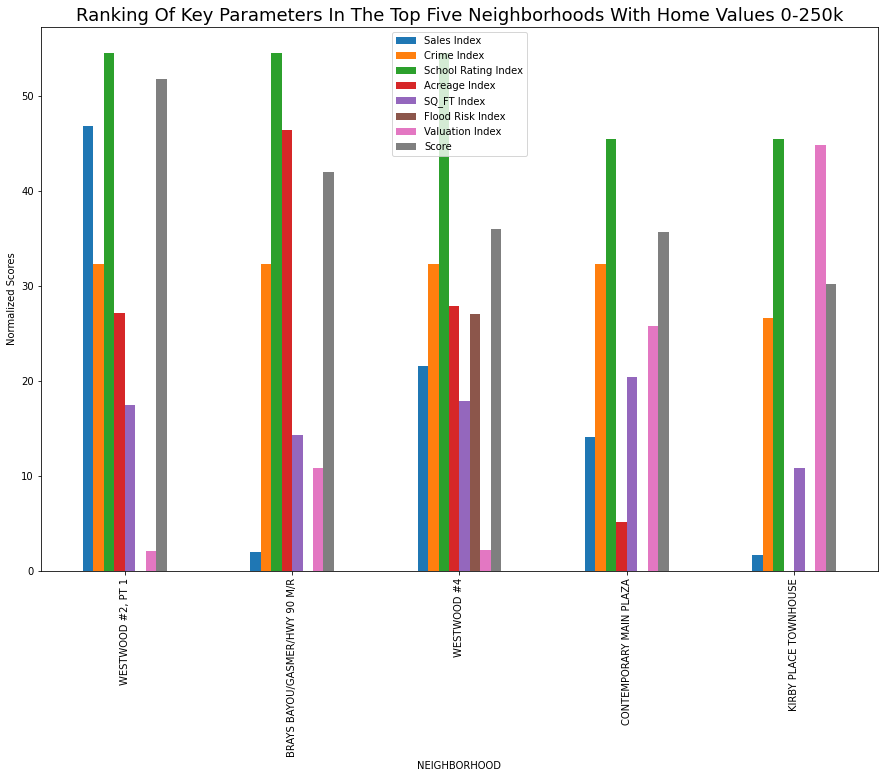

In [19]:
# Bar plot for budget= 0-250k
ranked_250k = ranked_250k.iloc[:,:-1]
ranked_250k.plot(kind='bar',figsize=(15,10))
plt.ylabel("Normalized Scores")
plt.title("Ranking Of Key Parameters In The Top Five Neighborhoods With Home Values 0-250k",fontsize=18)
plt.show()


In [20]:
#Add Map of Selected Neighborhoods
locations250=pd.merge(locations,ranked_250k,on="NEIGHBORHOOD")
locations250['Zip Code']=locations250['Zip Code'].map("{:.0f}".format)
locations250['Score']=locations250['Score'].map("{:,.2f}".format)
locate=locations250[['Latitude', 'Longitude']]

fig = gmaps.figure(map_type='TERRAIN', center=(29.7, -95.4), zoom_level=12,layout={
        'width': '1000px',
        'height': '700px',
        'padding': '3px',
        'border': '1px solid black'
})


info_box_template = """
<dl>
<dt>Neighborhood</dt><dd>{NEIGHBORHOOD}</dd>
<dt>Score</dt><dd>{Score}</dd>
<dt>ZIP_Code</dt><dd>{Zip Code}</dd>
</dl>
"""

info = [info_box_template.format(**row) for index, row in locations250.iterrows()]

markers = gmaps.marker_layer(locate, info_box_content= info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='1000px'))

In [21]:
# extract the top five neighborhoods for home values 250-500k
top_neighborhoods_500 = rank_all.loc[(rank_all['TOTAL_APPRAISED_VALUE_2019']>250000)&(rank_all['TOTAL_APPRAISED_VALUE_2019']<=500000),:]
top_500k_group = top_neighborhoods_500.groupby(['NEIGHBORHOOD']).mean()
ranked_500k = top_500k_group.sort_values('Score',ascending=False)
ranked_500k = ranked_500k.head()
ranked_500k.head(10)

,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index,Score,TOTAL_APPRAISED_VALUE_2019
NEIGHBORHOOD,,,,,,,,,
CHERRY HURST-ROW T/HS,65.168539,43.790058,68.188340,7.315633,30.028921,0.143472,13.375643,57.623787,495192.276901
AUBURN PLACE TH,1.498127,0.000000,90.909091,0.000000,29.509756,0.000000,63.762751,52.514378,461115.705882
ATWOOD VILLAS (DUPLEXES),0.561798,25.702393,90.909091,25.659419,25.891976,0.000000,24.879714,51.050258,486658.428571
WILLOWICK PLACE,4.307116,25.702393,100.000000,0.000000,27.776144,0.000000,20.117604,48.998002,450012.531915
DREXEL PLACE/LAS PALMAS,2.153558,25.702393,100.000000,0.000000,14.961233,0.000000,32.826912,45.808474,308814.250000


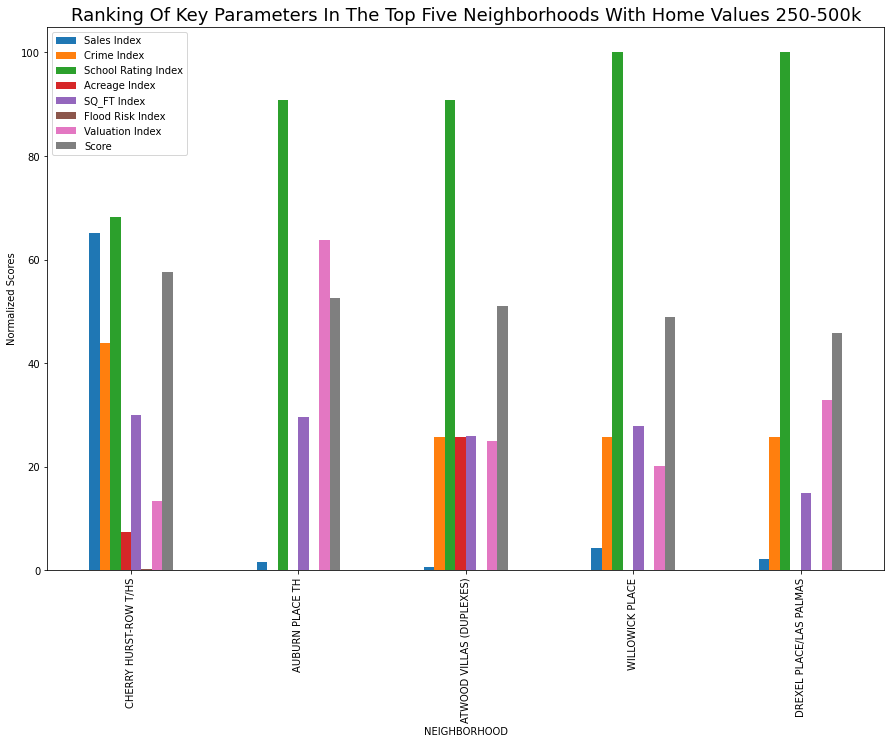

In [22]:
# Bar plot for budget=250-500k
ranked_500k = ranked_500k.iloc[:,:-1]
ranked_500k.plot(kind='bar',figsize=(15,10))
plt.ylabel("Normalized Scores")
plt.title("Ranking Of Key Parameters In The Top Five Neighborhoods With Home Values 250-500k",fontsize=18)
plt.show()

In [23]:
#Add Map of Selected Neighborhoods
locations500=pd.merge(locations,ranked_500k,on="NEIGHBORHOOD")
locations500['Zip Code']=locations500['Zip Code'].map("{:.0f}".format)
locations500['Score']=locations500['Score'].map("{:,.2f}".format)
locate=locations500[['Latitude', 'Longitude']]

fig = gmaps.figure(map_type='TERRAIN', center=(29.7, -95.4), zoom_level=12,layout={
        'width': '1000px',
        'height': '700px',
        'padding': '3px',
        'border': '1px solid black'
})


info_box_template = """
<dl>
<dt>Neighborhood</dt><dd>{NEIGHBORHOOD}</dd>
<dt>Score</dt><dd>{Score}</dd>
<dt>ZIP_Code</dt><dd>{Zip Code}</dd>
</dl>
"""

info = [info_box_template.format(**row) for index, row in locations500.iterrows()]

markers = gmaps.marker_layer(locate, info_box_content= info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='1000px'))

In [24]:
# extract the top five neighborhoods for home values 500-750k
top_neighborhoods_750 = rank_all.loc[(rank_all['TOTAL_APPRAISED_VALUE_2019']>500000)&(rank_all['TOTAL_APPRAISED_VALUE_2019']<=750000),:]
top_750k_group = top_neighborhoods_750.groupby(['NEIGHBORHOOD']).mean()
ranked_750k = top_750k_group.sort_values('Score',ascending=False)
ranked_750k = ranked_750k.head()
ranked_750k.head(10)

,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index,Score,TOTAL_APPRAISED_VALUE_2019
NEIGHBORHOOD,,,,,,,,,
HYDE PARK MAIN 6-ROW T/H,100.000000,32.524343,42.503614,7.815857,31.815757,0.000000,8.231140,63.994430,544158.155285
COLLEGE CT. PL. (ROW T/HS)(91),24.719101,0.000000,100.000000,8.226971,30.071383,0.000000,26.071519,62.863088,540422.822642
SUNSET TERR(N OF BISSONNET),12.546816,0.000000,98.855219,30.796058,25.893752,0.000000,19.651113,62.835942,726596.555556
WEST U - COLLEGE CT PL,19.850187,0.000000,91.250534,17.897518,27.592356,1.408451,0.000000,59.347205,718864.413146
COLLEGE CT PL.,3.464419,0.000000,100.000000,18.099930,29.248065,0.000000,20.666494,58.223431,659077.552632


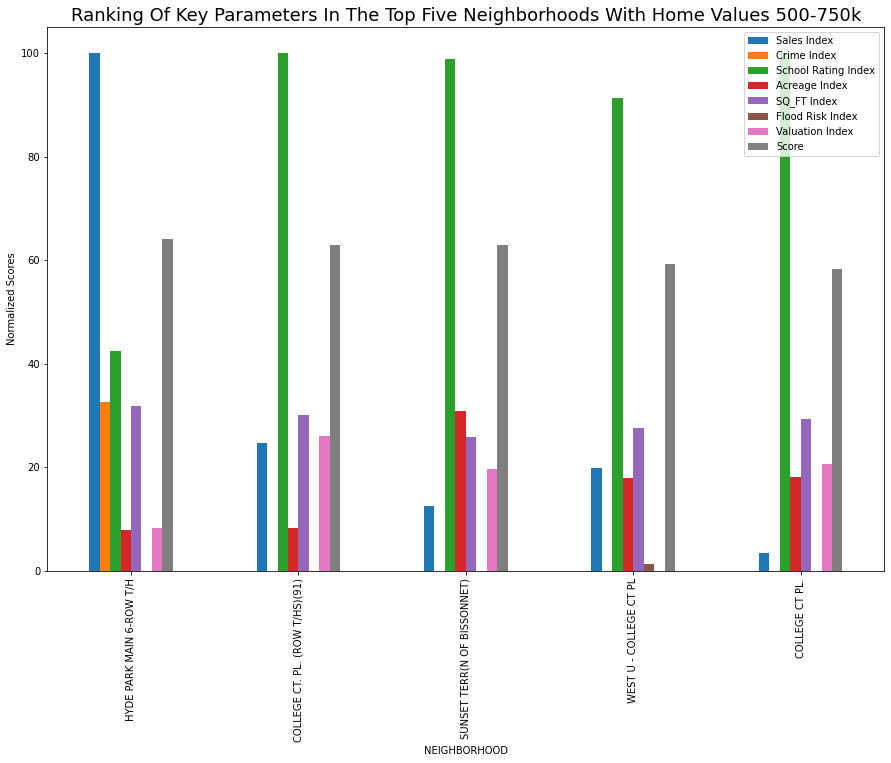

In [25]:
# Bar plot for budget=500-750k
ranked_750k = ranked_750k.iloc[:,:-1]
ranked_750k.plot(kind='bar',figsize=(15,10))
plt.ylabel("Normalized Scores")
plt.title("Ranking Of Key Parameters In The Top Five Neighborhoods With Home Values 500-750k",fontsize=18)
plt.show()

In [26]:
#Add Map of Selected Neighborhoods
locations750=pd.merge(locations,ranked_750k,on="NEIGHBORHOOD")
locations750['Zip Code']=locations750['Zip Code'].map("{:.0f}".format)
locations750['Score']=locations750['Score'].map("{:,.2f}".format)
locate=locations750[['Latitude', 'Longitude']]

fig = gmaps.figure(map_type='TERRAIN', center=(29.7, -95.4), zoom_level=12,layout={
        'width': '1000px',
        'height': '700px',
        'padding': '3px',
        'border': '1px solid black'
})


info_box_template = """
<dl>
<dt>Neighborhood</dt><dd>{NEIGHBORHOOD}</dd>
<dt>Score</dt><dd>{Score}</dd>
<dt>ZIP_Code</dt><dd>{Zip Code}</dd>
</dl>
"""

info = [info_box_template.format(**row) for index, row in locations750.iterrows()]

markers = gmaps.marker_layer(locate, info_box_content= info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='1000px'))

In [27]:
# extract the top five neighborhoods for home values 750-1000k
top_neighborhoods_1000 = rank_all.loc[(rank_all['TOTAL_APPRAISED_VALUE_2019']>750000)&(rank_all['TOTAL_APPRAISED_VALUE_2019']<=1000000),:]
top_1000k_group = top_neighborhoods_1000.groupby(['NEIGHBORHOOD']).mean()
ranked_1000k = top_1000k_group.sort_values('Score',ascending=False)
ranked_1000k = ranked_1000k.head()
ranked_1000k.head(10)

,Sales Index,Crime Index,School Rating Index,Acreage Index,SQ_FT Index,Flood Risk Index,Valuation Index,Score,TOTAL_APPRAISED_VALUE_2019
NEIGHBORHOOD,,,,,,,,,
AFTON OAKS,19.943820,25.702393,88.275276,34.497428,28.383238,0.0,16.778371,58.647918,799890.046729
HIGHLAND VLG/LYNN PARK ANNEX,14.887640,25.702393,98.465909,27.091516,23.775528,0.0,52.819349,58.287625,752004.787500
WEST LANE PLACE ROW T/H,14.138577,25.702393,88.935407,12.949631,39.951518,0.0,23.168501,54.950671,781930.105263
WEST LANE PLACE,0.842697,25.702393,85.454545,36.120429,36.911402,0.0,16.652855,54.347575,804438.500000
ROYDEN OAKS,3.277154,25.702393,95.202020,29.043052,28.039651,0.0,13.164037,53.919682,900065.527778


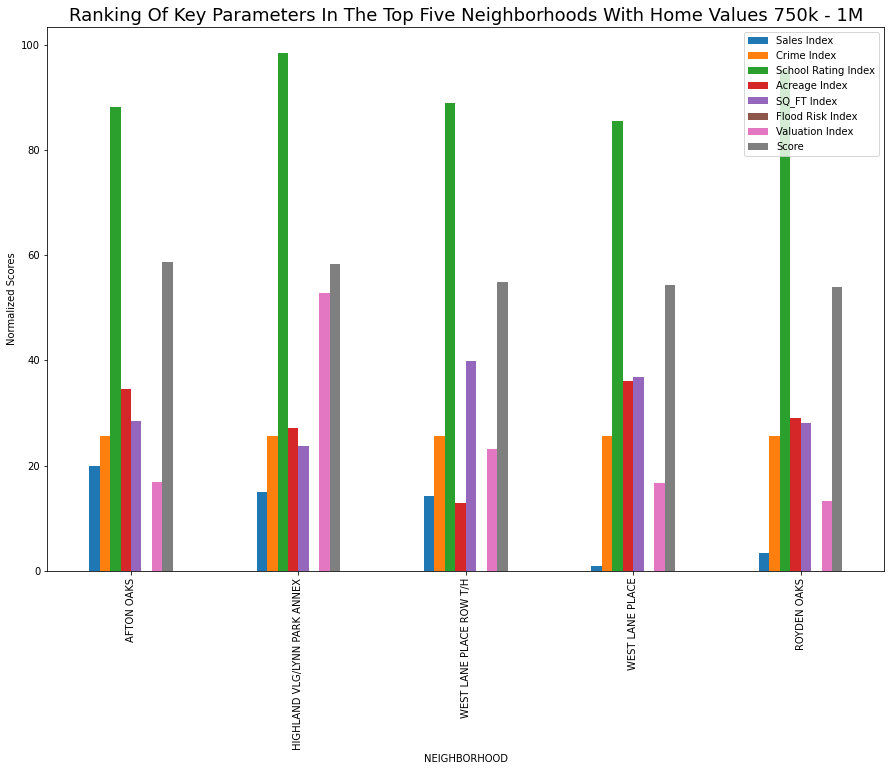

In [28]:
# Bar plot for budget=750k-1M
ranked_1000k = ranked_1000k.iloc[:,:-1]
ranked_1000k.plot(kind='bar',figsize=(15,10))
plt.ylabel("Normalized Scores")
plt.title("Ranking Of Key Parameters In The Top Five Neighborhoods With Home Values 750k - 1M",fontsize=18)
plt.show()

In [29]:
#Add Map of Selected Neighborhoods
locations1000=pd.merge(locations,ranked_1000k,on="NEIGHBORHOOD")
locations1000['Zip Code']=locations1000['Zip Code'].map("{:.0f}".format)
locations1000['Score']=locations1000['Score'].map("{:,.2f}".format)
locate=locations1000[['Latitude', 'Longitude']]

fig = gmaps.figure(map_type='TERRAIN', center=(29.7, -95.4), zoom_level=12,layout={
        'width': '1000px',
        'height': '700px',
        'padding': '3px',
        'border': '1px solid black'
})


info_box_template = """
<dl>
<dt>Neighborhood</dt><dd>{NEIGHBORHOOD}</dd>
<dt>Score</dt><dd>{Score}</dd>
<dt>ZIP_Code</dt><dd>{Zip Code}</dd>
</dl>
"""

info = [info_box_template.format(**row) for index, row in locations1000.iterrows()]

markers = gmaps.marker_layer(locate, info_box_content= info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='1000px'))